# MLP with word level embedding

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import torch.nn.functional as F

In [2]:
papers = pd.read_csv("data/sci_papers.csv")

In [3]:
df = papers
counts = df["category"].value_counts()
categories = df.category.unique()
others = counts.index[5:].tolist()
df.loc[df['category'].isin(others), 'category'] = 'others'


In [4]:
titles = df["title"]

# Create a list of all unique words by splitting titles into words and using set
unique_words = set()
for title in titles:
    # Split each title into words and convert to lowercase
    words = ''.join(char.lower() for char in title if char.isalnum() or char.isspace()).split()
    unique_words.update(words)

# Convert set back to list for easier manipulation
vocab = sorted(list(unique_words))
len(vocab)

63800

Each word is embbeded with a emb_dim dimensional vector. 

The sentence is represented by a vector of size emb_dim, which is the coordonate by coordonate average of the word vectors.

The sentence vector is then passed to a MLP 


In [5]:
# each word is embbeded in a emb_dim dimension space
# So each title is embbeded as a list of word embeddings 
# As each title has a different length we will resort to pooling methods

categories = df.category.unique()

wtoi = {t:i for i,t in enumerate(vocab)} # word to integer 
itow = {i:t for i,t in enumerate(vocab)} # integer to word

ttoi = {t:i for i,t in enumerate(titles)} # title to integer 
itot = {i:t for i,t in enumerate(titles)} # integer to title

ctoi = {c:i for i,c in enumerate(categories)} # category to integer
itoc = {i:c for i,c in enumerate(categories)} # integer to category


In [6]:
emb_dim = 30
C = torch.randn((len(vocab), emb_dim))
C[0]

tensor([ 0.5984,  0.1166,  0.1474, -1.4299, -1.2299,  0.7995, -0.2101,  1.0011,
         0.2856,  0.5609,  0.3540, -0.6441, -0.3139, -0.3215, -0.6150, -1.6148,
         1.0987, -0.3125, -0.6247,  0.4219,  0.4466,  0.6026,  0.6409, -1.2917,
         0.5796,  0.4842, -1.5345,  1.3355,  0.1281, -0.1124])

In [7]:

emb_titles = []
for t in titles:
    t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in t)
    words = t_clean.split()

    indices = [wtoi[w] for w in words if w in wtoi]
    word_embeddings = C[indices] # (nbr_words_in_title, emb_dim)
    avg_embedding = word_embeddings.mean(dim=0) # mean 
    
    emb_titles.append(avg_embedding)

emb_titles = torch.stack(emb_titles)
emb_titles.shape # (nbr_titles, emb_dim)

torch.Size([136238, 30])

In [8]:
def titles_embbeding(titles, C, poolingtype="avg"): 
    titles_emb = []
    for t in titles:
        t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in t)
        words = t_clean.split()

        indices = [wtoi[w] for w in words if w in wtoi]
        word_embeddings = C[indices] # (nbr_words_in_title, emb_dim)
        if poolingtype == "avg":
            emb = word_embeddings.mean(dim=0) # mean 
        elif poolingtype == "max":
            emb = word_embeddings.max(dim=0)[0] # max values without the indices
        else:
            print("Choose between 'avg' and 'max'")
        titles_emb.append(emb)

    titles_emb = torch.stack(titles_emb)
    return titles_emb

batch_titles = [itot[i] for i in range(0,5)]
print(titles_embbeding(batch_titles, C, 'max'))

tensor([[ 0.4892, -0.1160,  0.4057, -0.2339,  1.5972, -0.4955,  1.2582,  0.6009,
          0.7813,  1.2922,  0.2636,  0.9465, -0.1051,  0.6341,  1.0112,  0.8859,
          0.9358,  1.1212,  0.1544,  1.3685,  1.5000,  0.7720,  0.3694,  0.8938,
          1.8073,  1.1475, -0.9158,  0.9014,  1.5687, -0.1373],
        [ 1.4358,  1.9464,  1.3814,  1.4350,  2.0493,  1.4671,  1.3956,  1.6979,
          1.6733,  0.7331,  1.9784,  2.2129,  1.2336,  1.3956,  1.3041,  1.6798,
          1.7837,  1.9201,  1.3204,  1.2998,  1.6435,  0.7375,  2.4869,  1.0048,
          2.0744,  3.0224,  2.0416,  2.1518,  1.1932,  1.6238],
        [-0.4978,  1.0530,  1.3915,  2.5195,  0.7615,  1.6854,  0.8927,  1.1467,
          0.4579,  0.6247,  1.3082,  0.6138,  0.9806,  1.6423,  1.5586,  0.8439,
          0.7094,  1.9113,  1.7967,  1.9683, -0.1149,  2.3054,  1.7074,  1.6535,
          1.5462,  1.8463,  0.8848,  0.8988,  2.9982,  0.8522],
        [ 1.2018,  1.8434,  1.1947,  1.6610,  3.0617,  1.1127,  1.1555,  1.3613

In [9]:
print(emb_titles[0])  # prints the embedding of the first title

t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in titles[0])
words = t_clean.split()
word_embeddings = torch.stack([C[wtoi[w]] for w in words])
print(word_embeddings)  # prints embeddings of each word in the first title
print(torch.mean(word_embeddings, dim=0))  # prints the mean embedding across all words$

# we see that the mean pooling works
# In this simple example (2 words) we see that the embedded title is the coordinate-wise mean of the embedded words

# Now, we can train an MLP with the input beeing a title embbeding 

tensor([-0.1348, -0.5269, -0.2392, -0.3733,  0.4891, -1.1340,  0.5322,  0.2051,
         0.0089,  1.0585, -1.1755, -0.0537, -0.2156,  0.0857,  0.6751, -0.4259,
         0.2361,  0.3842, -0.5527, -0.1262,  0.3440,  0.0170, -1.0906, -0.0365,
         0.3032,  0.3486, -0.9186,  0.4938,  0.2902, -0.4918])
tensor([[ 0.4892, -0.1160,  0.4057, -0.5126,  1.5972, -0.4955, -0.1939,  0.6009,
         -0.7636,  0.8249, -2.6145,  0.9465, -0.1051,  0.6341,  0.3389, -1.7377,
          0.9358,  1.1212, -1.2598, -1.6209, -0.8120,  0.7720,  0.3694, -0.9667,
          1.8073,  1.1475, -0.9214,  0.0862, -0.9884, -0.1373],
        [-0.7589, -0.9379, -0.8842, -0.2339, -0.6191, -1.7726,  1.2582, -0.1908,
          0.7813,  1.2922,  0.2636, -1.0538, -0.3261, -0.4627,  1.0112,  0.8859,
         -0.4637, -0.3527,  0.1544,  1.3685,  1.5000, -0.7380, -2.5506,  0.8938,
         -1.2009, -0.4504, -0.9158,  0.9014,  1.5687, -0.8464]])
tensor([-0.1348, -0.5269, -0.2392, -0.3733,  0.4891, -1.1340,  0.5322,  0.2051,
  

In [37]:

def build_dataset(papers, n1, n2):  
    X = torch.arange(n1, n2)
    Y = torch.tensor([ctoi[papers.iloc[i]["category"]] for i in range(n1,n2)])
    #print(X.shape, Y.shape)
    return X, Y


In [39]:
import random
random.seed(42)
indices = list(range(len(papers)))
random.shuffle(indices)
papers_shuffled = papers.iloc[indices].reset_index(drop=True) # shuffled dataset 
n1 = int(0.8*len(papers_shuffled))
n2 = int(0.9*len(papers_shuffled))
Xtr, Ytr = build_dataset(papers_shuffled, 0, n1)
Xdev, Ydev = build_dataset(papers_shuffled, n1, n2)
Xte, Yte = build_dataset(papers_shuffled, n2, len(papers_shuffled))



In [50]:
titles = [itot[Xte[i].item()] for i in range(0, 5)]
cats = [itoc[Yte[i].item()] for i in range(0,5)]
print(titles)
print(cats)
print(papers_shuffled.iloc[ttoi["Simple Questions Generate Named Entity Recognition Datasets"]]["category"])

['AcTune: Uncertainty-aware Active Self-Training for Semi-Supervised\n  Active Learning with Pretrained Language Models', 'Harnessing Cross-lingual Features to Improve Cognate Detection for\n  Low-resource Languages', 'CrossSum: Beyond English-Centric Cross-Lingual Summarization for 1,500+\n  Language Pairs', 'Simple Questions Generate Named Entity Recognition Datasets', 'Khmer Word Search: Challenges, Solutions, and Semantic-Aware Search']
['Machine Learning', 'Machine Learning', 'Machine Learning', 'others', 'others']
others


In [70]:
nbr_added_layers = 1
nbr_neurons_hidden = [256 for _ in range(nbr_added_layers)]
nbr_neurons_first = 256
nbr_categories = len(categories)
nbr_titles = len(titles)
vocab_size = len(vocab)
emb_dim = 10

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim, nbr_neurons_first), generator=g) / nbr_neurons_first**0.5 # kaiming init
b1 = torch.randn(nbr_neurons_first, generator=g) * 0.1

Ws = []
bs = []
parameters = [C, W1, b1]
for i in range(0, nbr_added_layers):
    if i == 0:
        W = torch.randn((nbr_neurons_first, nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    else : 
        W = torch.randn((nbr_neurons_hidden[i], nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    
    b = torch.randn(nbr_neurons_hidden[i], generator=g) * 0.1
    parameters.append(W)
    parameters.append(b)
    Ws.append(W)
    bs.append(b)

Wlast = torch.randn((nbr_neurons_hidden[-1], nbr_categories), generator=g) / nbr_neurons_hidden[-1]**0.5
blast = torch.randn((nbr_categories), generator=g) * 0.1

parameters.append(Wlast)
parameters.append(blast)

for p in parameters:
    print(p.shape)

print(sum(p.nelement() for p in parameters))

torch.Size([63800, 10])
torch.Size([10, 256])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256, 6])
torch.Size([6])
708150


In [71]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, lri = [], [], []

In [63]:
n = 20000
batch_size = 32
lre = torch.linspace(-3, 0, n)
lrs = 10**lre #from 0.001 to 1 exponentielly stepped 
pooling_type = "avg"

for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Get the titles for these indices
    batch_titles = [itot[i.item()] for i in ixs]
    
    # Calculate embeddings for these titles using average pooling
    emb = titles_embbeding(batch_titles, C, pooling_type)
    
    # Forward pass through the network
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Use modulo to cycle through learning rates
    #lr = lrs[i % len(lrs)]
    #lr = 0.1 if i<0.9*n else 0.01
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad 

    stepi.append(i)
    #lri.append(lr.item())
    lossi.append(loss.item())


In [64]:
def deep_model_test(X,Y):
    # Get the titles for these indices
    batch_titles = [itot[i.item()] for i in X]
    
    # Stack all embeddings into a single tensor
    emb = titles_embbeding(batch_titles, C, pooling_type)
    
    # Forward pass through the network
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Y) 


    return loss

ldev = deep_model_test(Xdev, Ydev)
ltest = deep_model_test(Xte, Yte)
ltrain = deep_model_test(Xtr, Ytr)
print("ltrain : ", ltrain)
print("dev : ", ldev)
print("test : ", ltest)

# with 60k iterations (avg_pooling, emb_dim = 10, 1 hidden layer, 256 neurons per layer)
#ltrain :  tensor(1.1399, grad_fn=<NllLossBackward0>)
#dev :  tensor(1.5250, grad_fn=<NllLossBackward0>)
#test :  tensor(1.5250, grad_fn=<NllLossBackward0>)
# and the loss isn't platauing 

# Same with max pooling : 
# ltrain : 1.1614
# dev :  1.7479
# test : 1.7479

ltrain :  tensor(1.6934, grad_fn=<NllLossBackward0>)
dev :  tensor(1.6989, grad_fn=<NllLossBackward0>)
test :  tensor(1.6989, grad_fn=<NllLossBackward0>)


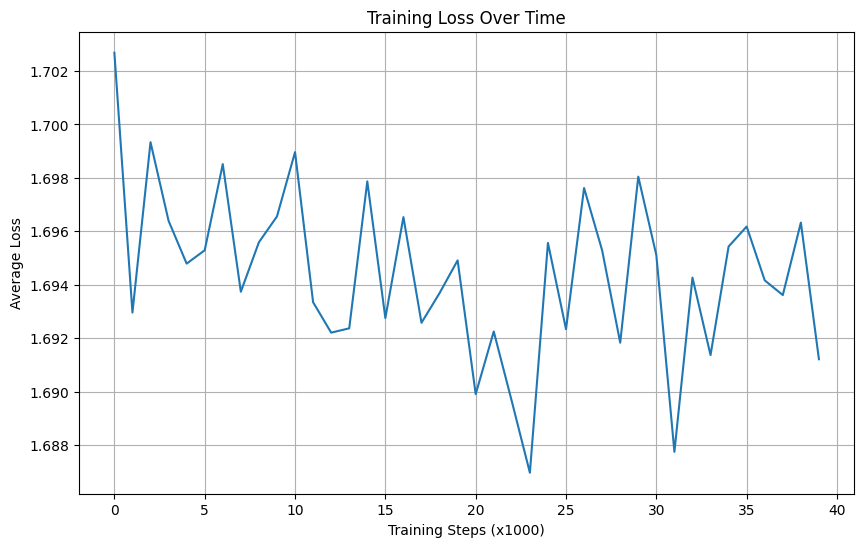

In [66]:
# Plot 1: Loss over training iterations (averaged over a window size)
window_size = 1000  # adjust this value to get smoother/rougher plot
plt.figure(figsize=(10, 6))
losses = torch.tensor(lossi)
n = len(losses)
n_windows = n // window_size
averaged_losses = losses[:n_windows * window_size].view(-1, window_size).mean(1)


plt.plot(averaged_losses)
plt.xlabel(f'Training Steps (x{window_size})')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Plot 2: Loss vs Learning Rate (averaged over 100 iterations)
# plt.figure()
# plt.plot(torch.tensor(lri).view(-1, 100).mean(1), torch.tensor(lossi).view(-1, 100).mean(1))
# plt.xlabel('Learning Rate')
# plt.ylabel('Average Loss')
# plt.title('Loss vs Learning Rate')
# plt.xscale('log')  # Learning rate is typically better viewed in log scale
# plt.grid(True)
# plt.show()

In [69]:
# forward
batch_titles = [itot[i.item()] for i in Xte]
emb = titles_embbeding(batch_titles, C, pooling_type)

x = torch.tanh(emb @ W1 + b1)  
for W, b in zip(Ws, bs): 
    x = torch.tanh(x @ W + b)
logits = x @ Wlast + blast
probs = F.softmax(logits, dim=1)

# Display last 5 results
print("5 papers predictions:")
indices = torch.randint(0, len(papers_shuffled.iloc[n2:]), (5,))
for idx in indices:
    print("\nTitle:", papers_shuffled.iloc[n2:].iloc[idx.item()]['title'])
    print("True category:", papers_shuffled.iloc[n2:].iloc[idx.item()]['category'])
    print("\nPredicted probabilities:")
    # Sort probabilities in descending order and get corresponding categories
    sorted_probs = [(prob.item(), cat) for prob, cat in zip(probs[idx.item()], categories)]
    sorted_probs.sort(reverse=True)
    for prob, cat in sorted_probs:
        print(f"{cat}: {prob*100:.2f}%")

5 papers predictions:

Title: Fake news detection using parallel BERT deep neural networks
True category: Computation and Language (Natural Language Processing)

Predicted probabilities:
Machine Learning: 30.33%
Computer Vision and Pattern Recognition: 21.37%
Computation and Language (Natural Language Processing): 18.46%
others: 12.96%
Artificial Intelligence: 9.84%
Machine Learning (Statistics): 7.04%

Title: Talking to the crowd: What do people react to in online discussions?
True category: Computation and Language (Natural Language Processing)

Predicted probabilities:
Machine Learning: 30.14%
Computer Vision and Pattern Recognition: 21.72%
Computation and Language (Natural Language Processing): 19.33%
others: 12.54%
Artificial Intelligence: 9.39%
Machine Learning (Statistics): 6.89%

Title: Unsupervised Learning of Sequence Representations by Autoencoders
True category: Computer Vision and Pattern Recognition

Predicted probabilities:
Machine Learning: 30.12%
Computer Vision and Pa

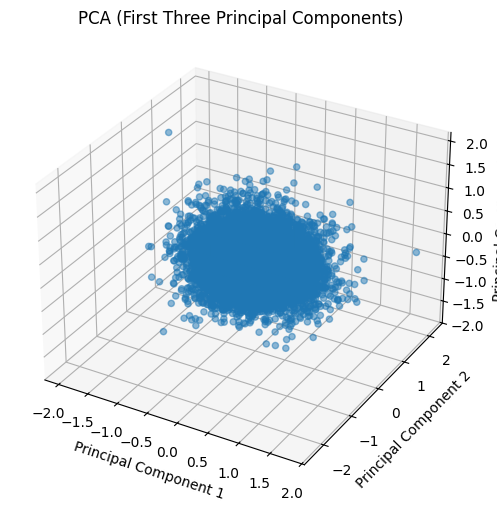

Composante 1: 14.77%
Composante 2: 13.81%
Composante 3: 11.44%
Composante 4: 9.79%
Composante 5: 9.61%
Composante 6: 8.97%
Composante 7: 8.93%
Composante 8: 7.68%
Composante 9: 7.65%
Composante 10: 7.34%


In [61]:
# We'll perform PCA by hand on the 'emb' tensor.
# 1. Detach the tensor and center the data
X = emb.detach()
X_centered = X - X.mean(dim=0)

# 2. Compute the covariance matrix (using Bessel's correction)
cov = (X_centered.t() @ X_centered) / (X_centered.shape[0] - 1)

# 3. Compute the eigenvalues and eigenvectors. Since the covariance matrix is symmetric, we can use torch.linalg.eigh.
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# 4. Sort the eigenvalues (and corresponding eigenvectors) in descending order
sorted_indices = torch.argsort(eigenvalues, descending=True)
top3_eigenvectors = eigenvectors[:, sorted_indices[:3]]

# 5. Project the centered data onto the top 2 eigenvectors (principal components)
proj = X_centered @ top3_eigenvectors

# 6. Plot the first three principal components in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(proj[:, 0].numpy(), proj[:, 1].numpy(), proj[:, 2].numpy(), alpha=0.5)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("PCA (First Three Principal Components)")
plt.show()

sorted_eigenvalues = eigenvalues[sorted_indices]
explained_variance_ratio = sorted_eigenvalues[:10] / sorted_eigenvalues.sum()
for i, ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Composante {i}: {ratio.item() * 100:.2f}%")


Results for Training Set:
Accuracy: 0.2943


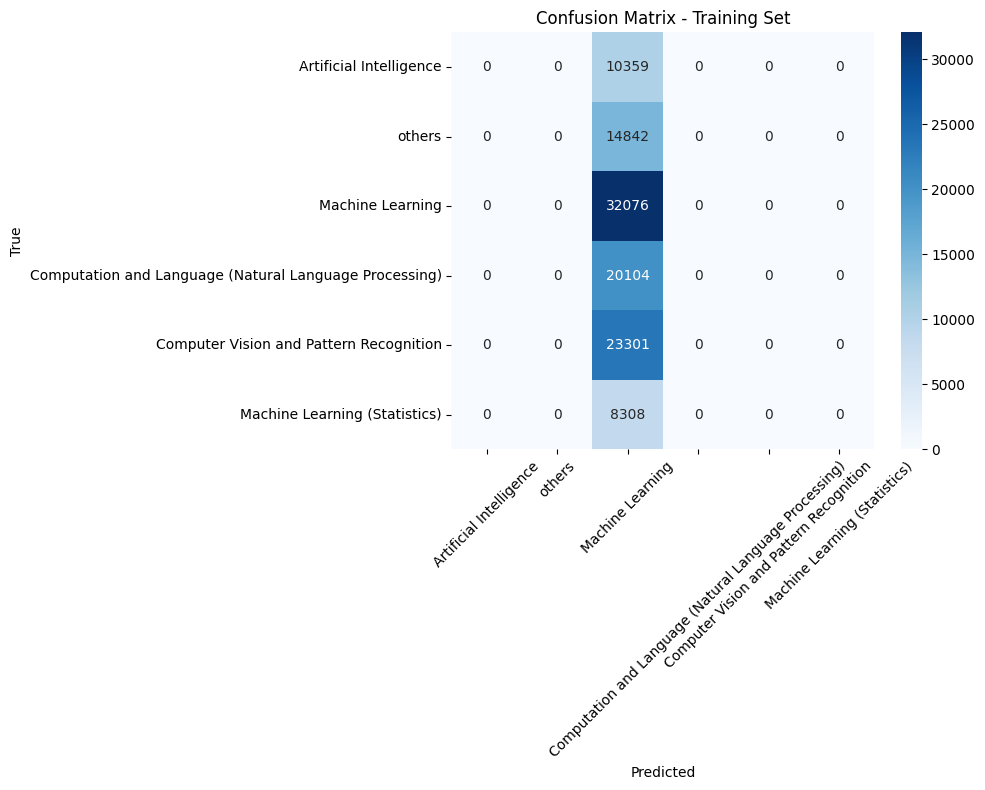


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.00      0.00      0.00     10359
                                                others       0.00      0.00      0.00     14842
                                      Machine Learning       0.29      1.00      0.45     32076
Computation and Language (Natural Language Processing)       0.00      0.00      0.00     20104
               Computer Vision and Pattern Recognition       0.00      0.00      0.00     23301
                         Machine Learning (Statistics)       0.00      0.00      0.00      8308

                                              accuracy                           0.29    108990
                                             macro avg       0.05      0.17      0.08    108990
                                          weighted avg       0.09      0.29      0.13    108990



c:\Users\cheri\nsi\M1\arxiv\SciPaperClassifier\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheri\nsi\M1\arxiv\SciPaperClassifier\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheri\nsi\M1\arxiv\SciPaperClassifier\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m


Results for Validation Set:
Accuracy: 0.2888


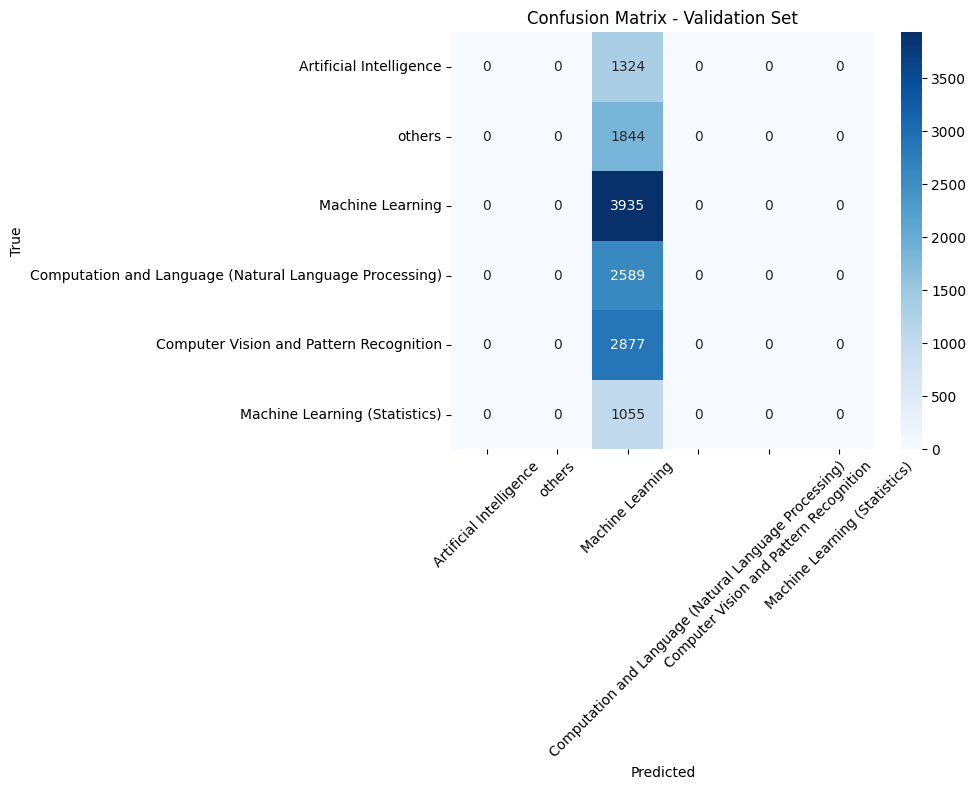


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.00      0.00      0.00      1324
                                                others       0.00      0.00      0.00      1844
                                      Machine Learning       0.29      1.00      0.45      3935
Computation and Language (Natural Language Processing)       0.00      0.00      0.00      2589
               Computer Vision and Pattern Recognition       0.00      0.00      0.00      2877
                         Machine Learning (Statistics)       0.00      0.00      0.00      1055

                                              accuracy                           0.29     13624
                                             macro avg       0.05      0.17      0.07     13624
                                          weighted avg       0.08      0.29      0.13     13624



c:\Users\cheri\nsi\M1\arxiv\SciPaperClassifier\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheri\nsi\M1\arxiv\SciPaperClassifier\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheri\nsi\M1\arxiv\SciPaperClassifier\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m


Results for Test Set:
Accuracy: 0.2918


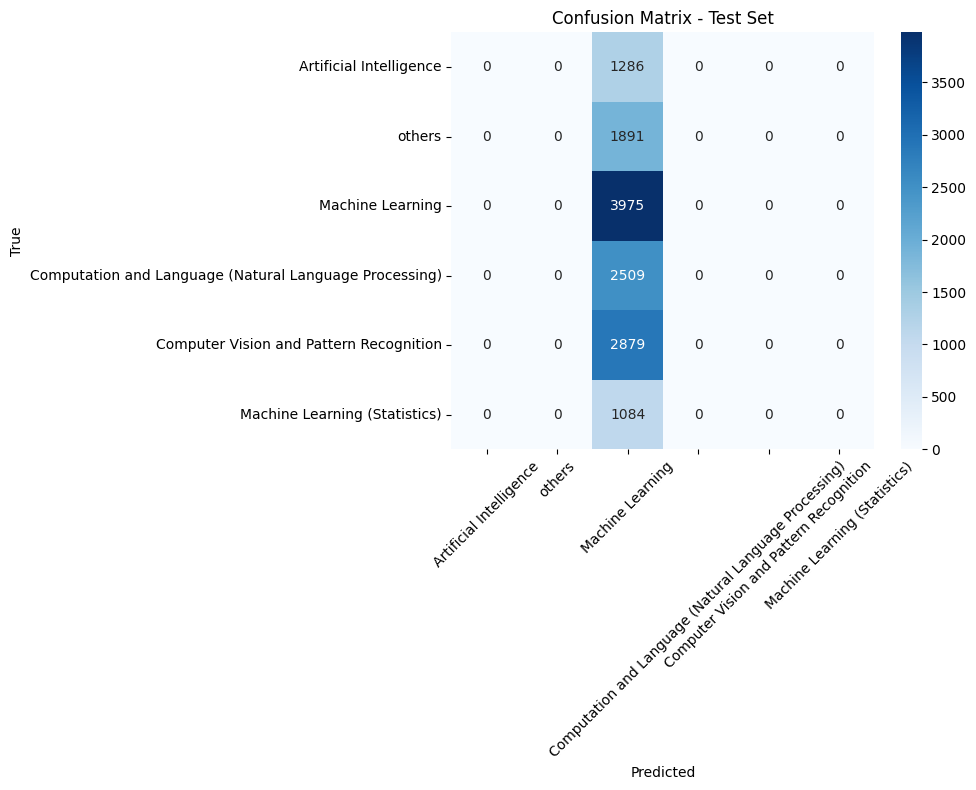


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.00      0.00      0.00      1286
                                                others       0.00      0.00      0.00      1891
                                      Machine Learning       0.29      1.00      0.45      3975
Computation and Language (Natural Language Processing)       0.00      0.00      0.00      2509
               Computer Vision and Pattern Recognition       0.00      0.00      0.00      2879
                         Machine Learning (Statistics)       0.00      0.00      0.00      1084

                                              accuracy                           0.29     13624
                                             macro avg       0.05      0.17      0.08     13624
                                          weighted avg       0.09      0.29      0.13     13624



c:\Users\cheri\nsi\M1\arxiv\SciPaperClassifier\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheri\nsi\M1\arxiv\SciPaperClassifier\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheri\nsi\M1\arxiv\SciPaperClassifier\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [68]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Import additional metrics

def evaluate_model(X, Y, split_name=""):
    # Forward pass
    batch_titles = [itot[i.item()] for i in X]
    emb = titles_embbeding(batch_titles, C, pooling_type)
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    probs = F.softmax(logits, dim=1)
    
    # Get predictions
    predictions = torch.argmax(probs, dim=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(Y.numpy(), predictions.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(Y.numpy(), predictions.numpy())
    
    # Print results
    print(f"\nResults for {split_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[itoc[i] for i in range(len(categories))],
                yticklabels=[itoc[i] for i in range(len(categories))])
    plt.title(f'Confusion Matrix - {split_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y.numpy(), predictions.numpy(), 
                              target_names=[itoc[i] for i in range(len(categories))]))
    
    return accuracy, predictions

# Evaluate on all splits
train_acc, train_preds = evaluate_model(Xtr, Ytr, "Training Set")
val_acc, val_preds = evaluate_model(Xdev, Ydev, "Validation Set")
test_acc, test_preds = evaluate_model(Xte, Yte, "Test Set")

### Conclusion : 

We beat the title embedding model without any optimization and with a smaller model. 

Best result so far : 
- ltrain :  0.6415
- dev : 0.7594
- test : 0.7594

with the following hyperparameters :
- emb_dim : 10
- added hidden layer : 1
- hidden layer size : 100
- learning rate : 0.1 and 0.01 in the last 10%
- batch size : 32
- 1M iterations